In [1]:
# !pip3 install wordcloud nltk spacy

In [2]:
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import spacy
from spacy.util import compounding, minibatch

import warnings
warnings.filterwarnings("ignore")

In [3]:
# nltk.download('stopwords')

In [4]:
def random_colours(number_of_colors):
    """
    sample function for random colours generation.
    Input: 
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following foramt: ['#E86DA4']
    """
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

In [5]:
!pwd

/home/mytsl02451/Shreyash/Data-Science-Practice/Comments_analysis


In [6]:
train = pd.read_csv('comment_analysis/tweet-sentiment-extraction/train.csv')
test = pd.read_csv('comment_analysis/tweet-sentiment-extraction/test.csv')
ss = pd.read_csv('comment_analysis/tweet-sentiment-extraction/sample_submission.csv')

In [7]:
train.shape, test.shape

((27481, 4), (3534, 3))

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [9]:
train.dropna(inplace=True)

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


#### EDA

In [11]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [12]:
train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11117


In [13]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text', ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


<Axes: xlabel='sentiment', ylabel='count'>

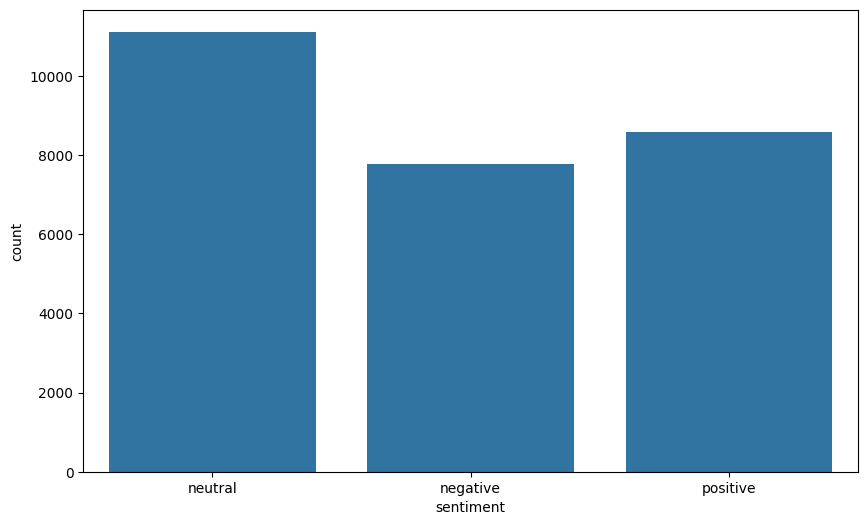

In [14]:
plt.figure(figsize=(10,6))
sns.countplot(x='sentiment',data=train)

In [15]:
# fig = go.Figure(go.Funnelarea(
#     text = temp.sentiment,
#     values = temp.text,
#     title={"position":"top center", "text":"Funnel-Chart of Sentiment Distribution"}
# ))
# fig.show()

In [16]:
def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    
    return float(len(c)/len(a)+len(b)-len(c))

In [17]:
results_jaccard = []

for ind, row in train.iterrows():
    sentenance1 = row.text
    sentenance2 = row.selected_text
    
    jaccard_score = jaccard(sentenance1, sentenance2)
    results_jaccard.append([sentenance1, sentenance2, jaccard_score])

In [18]:
jaccard = pd.DataFrame(results_jaccard, columns=['text','selected_text','jaccard_score'])
train = train.merge(jaccard, how='outer')

In [19]:
train['Num_words_ST'] = train['selected_text'].apply(lambda x:len(str(x).split()))
train['Num_words_text'] = train['text'].apply(lambda x:len(str(x).split()))
train['difference_in_words'] = train['Num_words_text'] - train['Num_words_ST']

In [20]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_words_text,difference_in_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,1.200000,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11


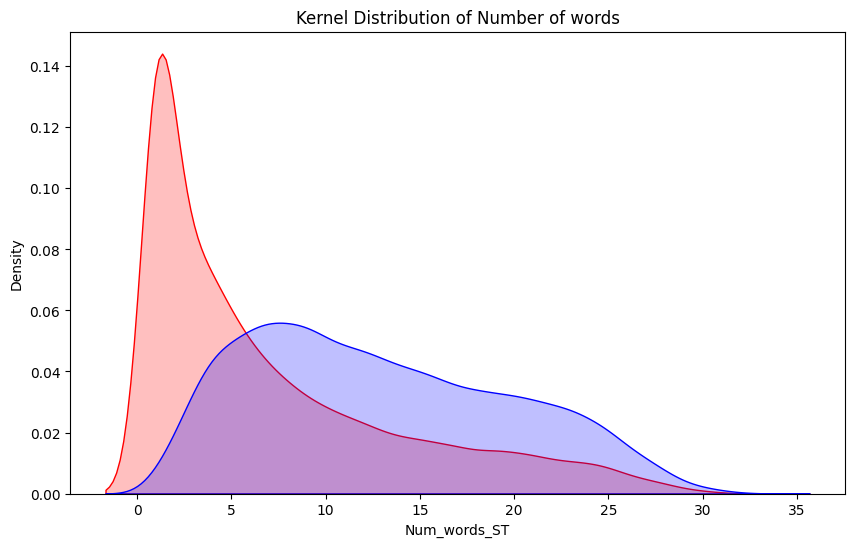

In [21]:
"""hist_data = [train['Num_words_ST'], train['Num_words_text']]

group_labels = ['Selected_Text','Text']

fig = ff.create_distplot(hist_data, group_labels, show_curve=False)
fig.update_layout(title_text="Distribution of Number of Words")
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue"
)
fig.show()"""

plt.figure(figsize=(10,6))
p1 = sns.kdeplot(train['Num_words_ST'], shade=True, color='r').set_title('Kernel Distribution of Number of words')
p1 = sns.kdeplot(train['Num_words_text'], shade=True, color='b')

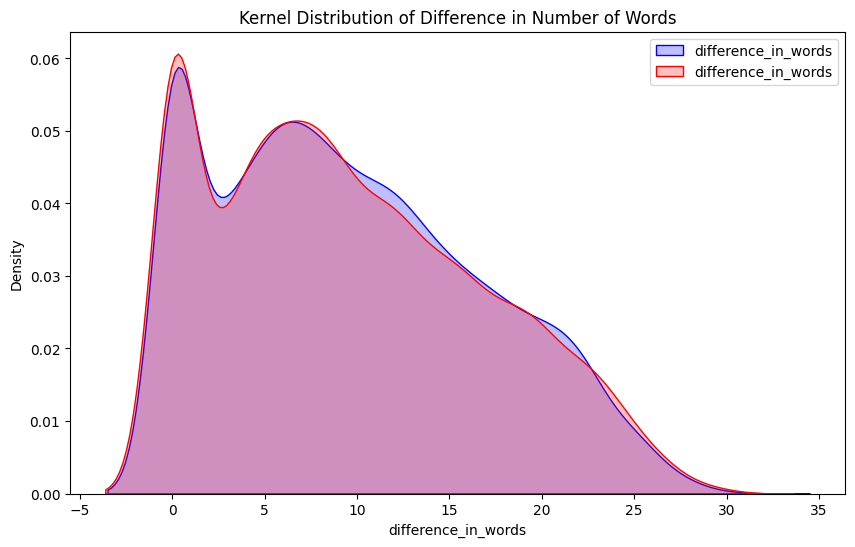

In [22]:
plt.figure(figsize=(10,6))
p1 = sns.kdeplot(train[train['sentiment'] == 'positive']['difference_in_words'], shade=True, color='b').set_title("Kernel Distribution of Difference in Number of Words")
p2 = sns.kdeplot(train[train['sentiment'] == 'negative']['difference_in_words'], shade=True, color='r')
plt.legend(labels=['difference_in_words','difference_in_words'])

<Axes: xlabel='difference_in_words'>

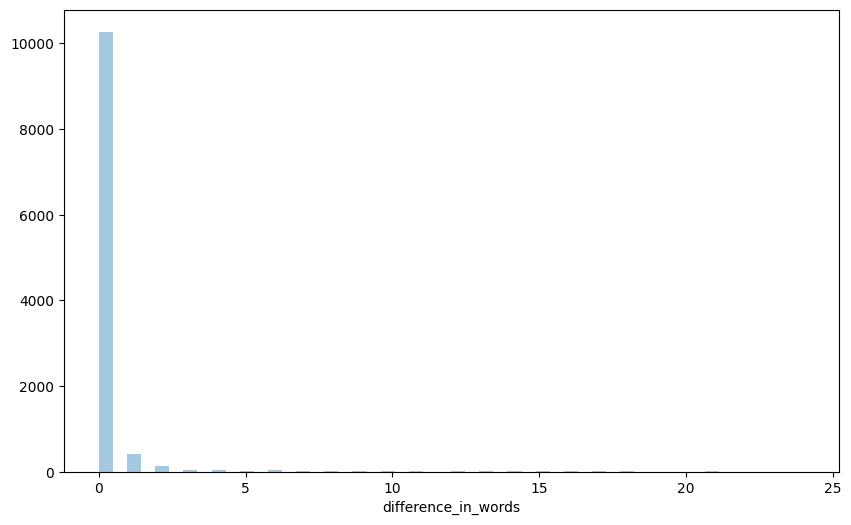

In [23]:
plt.figure(figsize=(10,6))
sns.distplot(train[train['sentiment'] == 'neutral']['difference_in_words'], kde=False)

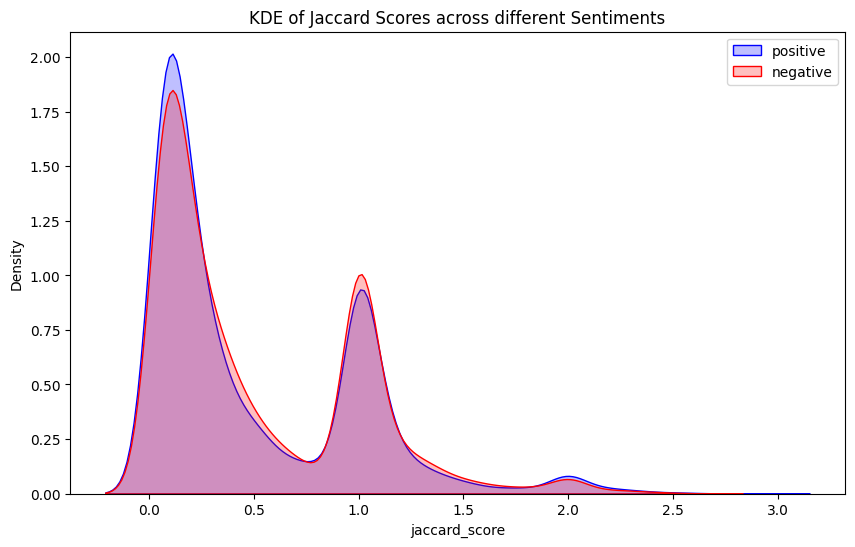

In [24]:
plt.figure(figsize=(10,6))
p1 = sns.kdeplot(train[train['sentiment'] == 'positive']['jaccard_score'], shade=True, color='b').set_title("KDE of Jaccard Scores across different Sentiments")
p2 = sns.kdeplot(train[train['sentiment'] == 'negative']['jaccard_score'], shade=True, color='r')
plt.legend(labels=['positive','negative'])

<Axes: xlabel='jaccard_score'>

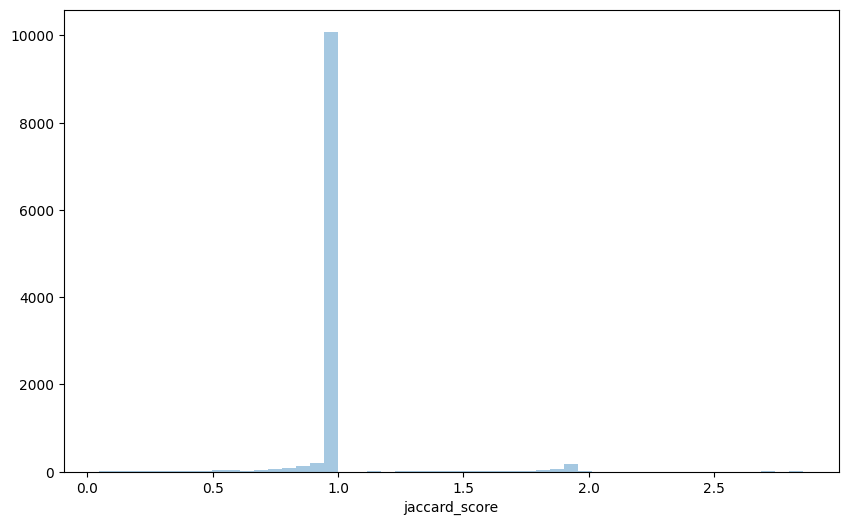

In [25]:
plt.figure(figsize=(10,6))
sns.distplot(train[train['sentiment'] == 'neutral']['jaccard_score'], kde=False)

We can see some interesting trends here:
1. Positive and Negative tweets have high kurtosis and thus values are concentrated in the two regions and high density.
2. Neutral tweets have a low kurtosis value and their is bump in density near values of 1.

Kurtosis is the measure of how peaked a distribution is and how much spread it is aroind the peak.
Skewness measures how much a curve deviates from a normal distribution.

Conclusion of EDA

We can see from jaccard score plot that there is peak for positive and negative plot aound score 1. That means there is cluster of tweets where there is a high similarity between text and selected texts, if we can find those clusters then we can predict text for selected texts for those tweets irrespective of segment.

In [26]:
k = train[train['Num_words_text']<=2]

In [27]:
# k['jaccard_score'].mean()
# k.groupby('sentiment').mean()['jaccard_score']
# Error "NotImplementedError" is occuring, otherwise ans will look like 
# Sentiment
# negative 0.788580
# positive 0.977895
# neutral 0.765700

we can see that there is similarity between text and selected text.

In [28]:
k[k['sentiment']=='positive']

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_words_text,difference_in_words
68,fa2654e730,Chilliin,Chilliin,positive,1.0,1,1,0
80,bbbc46889b,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,positive,1.0,2,2,0
170,f3d95b57b1,good morning,good morning,positive,1.0,2,2,0
278,89d5b3f0b5,Thanks,Thanks,positive,1.0,1,1,0
429,a78ef3e0d0,Goodmorning,Goodmorning,positive,1.0,1,1,0
...,...,...,...,...,...,...,...,...
26689,e80c242d6a,Goodnight;,Goodnight;,positive,1.0,1,1,0
26725,aad244f37d,*hug*,*hug*,positive,1.0,1,1,0
26842,a46571fe12,congrats!,congrats!,positive,1.0,1,1,0
26959,49a942e9b1,Happy birthday.,Happy birthday.,positive,1.0,2,2,0


Thus it is clear that most of the times, text is used as selected text. We can improve this by preprocessing the text which have word length less than 3. We will remember this information and use it in model building.

Cleaning the corpus

In [29]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove links, remove punctuation and 
    remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]','',text)
    text = re.sub('https?://\S+|www.\.\S+','',text)
    text = re.sub('<.*?>+','',text)
    text = re.sub('[%s]'%re.escape(string.punctuation),'',text)
    text = re.sub('\n','',text)
    text = re.sub('\w*\d\w*','',text)
    
    return text

In [30]:
train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))

In [31]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_words_text,difference_in_words
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,1.000000,7,7,0
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me,bullying me,negative,1.200000,2,5,3
3,9642c003ef,what interview leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,0.214286,3,14,11


Most common words in our target-selected text

In [32]:
train['temp_list'] = train['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['common_words','count']
# method 1
# temp.style.background_gradient(cmap='Blues')

# method 2
fig =  px.bar(temp, x='count', y='common_words', title="Common Words in Selected Text", orientation='h',
              width = 700, height=700, color='common_words')
fig.show()

Here, we cleaned our dataset, we didn't remove the stop words, and hence we can see the most common word is 'to'.
Let's try again after removing the stopwords.

In [33]:
def remove_stopwords(x):
    return [y for y in x if y not in stopwords.words('english')]

train['temp_list'] = train['temp_list'].apply(lambda x: remove_stopwords(x))

In [34]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,good,1251
2,day,1058
3,love,909
4,happy,852
5,like,774
6,get,772
7,dont,765
8,go,700
9,cant,613
10,work,612


In [35]:
fig = px.treemap(temp, path=['Common_words'], values='count', title='Tree of Most Common Words')
fig.show()

Lets look at the most common words in Text

In [36]:
train['temp_list1'] = train['text'].apply(lambda x: str(x).split())             # List of wrods in every row for text
train['temp_list1'] = train['temp_list1'].apply(lambda x: remove_stopwords(x))  # Removing Stopwords

In [37]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
1,good,1251
2,day,1058
3,love,909
4,happy,852
5,like,774
6,get,772
7,dont,765
8,go,700
9,cant,613
10,work,612


In [38]:
fig =  px.bar(temp, x='count', y='Common_words', title="Common Words in Text", orientation='h',
              width = 700, height=700, color='Common_words')
fig.show()

Most Common Words from Setiment Wise

In [39]:
Positive_sent = train[train['sentiment']=='positive'] 
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

In [40]:
# Most Common Positive Words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,good,826
1,happy,730
2,love,697
3,day,456
4,thanks,439
5,great,364
6,fun,287
7,nice,267
8,mothers,259
9,hope,245


In [41]:
# Most Common Negative Words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
0,im,452
1,miss,358
2,sad,343
3,sorry,300
4,bad,246
5,hate,230
6,dont,221
7,cant,201
8,sick,166
9,like,162


In [42]:
# Most Common Neutral Words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Reds')

,Common_words,count
0,im,1039
1,get,612
2,go,569
3,day,492
4,dont,482
5,going,472
6,work,467
7,like,445
8,got,441
9,today,427


Lets look at unique words in each segment

In [43]:
raw_text = [word for word_list in train['temp_list1'] for word in word_list]

In [44]:
def words_unique(sentiment, numwords, raw_words):
    allother = []
    for item in train[train.sentiment != sentiment]['temp_list1']:
        for word in item:
            allother.append(word)
    allother = list(set(allother))
    
    specificonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.sentiment == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
            
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns=['words','count'])
    
    return Unique_words

In [45]:
# Positive Tweets
Unique_positive = words_unique('positive',20,raw_text)
print("The Top 20 unique words in Positive Tweets are:")
Unique_positive.style.background_gradient(cmap='Greens')

The Top 20 unique words in Positive Tweets are:


,words,count
0,congratulations,29
1,thnx,10
2,appreciated,8
3,shared,7
4,presents,7
5,greetings,7
6,blessings,6
7,mothersday,6
8,mcr,6
9,coolest,6


In [46]:
fig = px.treemap(Unique_positive, path=['words'], values='count', title="Tree of Unique Positive Words")
fig.show()

In [49]:
# Negative Tweets
Unique_negative = words_unique('negative',20,raw_text)
print("The Top 20 unique words in Negative Tweets are:")
Unique_negative.style.background_gradient(cmap='Reds')

The Top 20 unique words in Negative Tweets are:


,words,count
0,ache,12
1,suffering,9
2,allergic,7
3,cramps,7
4,saddest,7
5,pissing,7
6,sob,6
7,dealing,6
8,devastated,6
9,noes,6


In [50]:
# Neutral Tweets
Unique_neutral = words_unique('neutral',20,raw_text)
print("The Top 20 unique words in Neutral Tweets are:")
Unique_neutral.style.background_gradient(cmap='Oranges')

The Top 20 unique words in Neutral Tweets are:


,words,count
0,settings,9
1,explain,7
2,mite,6
3,hiya,6
4,reader,5
5,pr,5
6,sorta,5
7,fathers,5
8,enterprise,5
9,guessed,5


By Looking at Unique words of each sentiment, we now have much more clarity about the data, these unique words are very strong determiners of Sentiment of tweets.

It's time for WordClouds

In [51]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0, 16.0), color='white',
                   title=None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u','im'}
    stopwords = stopwords.union(more_stopwords)
    
    wordcloud = WordCloud(background_color=color,
                          stopwords=stopwords,
                          max_words=max_words,
                          max_font_size=max_font_size,
                          random_state=42,
                          width=400,
                          height=200,
                          mask=mask)
    
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear');
        plt.title(title, fontdict={'size':title_size,
                                   'verticalalignment':'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size':title_size, 'color':'black',
                                   'verticalalignment':'bottom'})
        
    plt.axis('off');
    plt.tight_layout()

In [62]:
pos_mask = np.array(Image.open('/home/mytsl02451/Shreyash/Data-Science-Practice/Comments_analysis/comment_analysis/twitter_mask.png'))

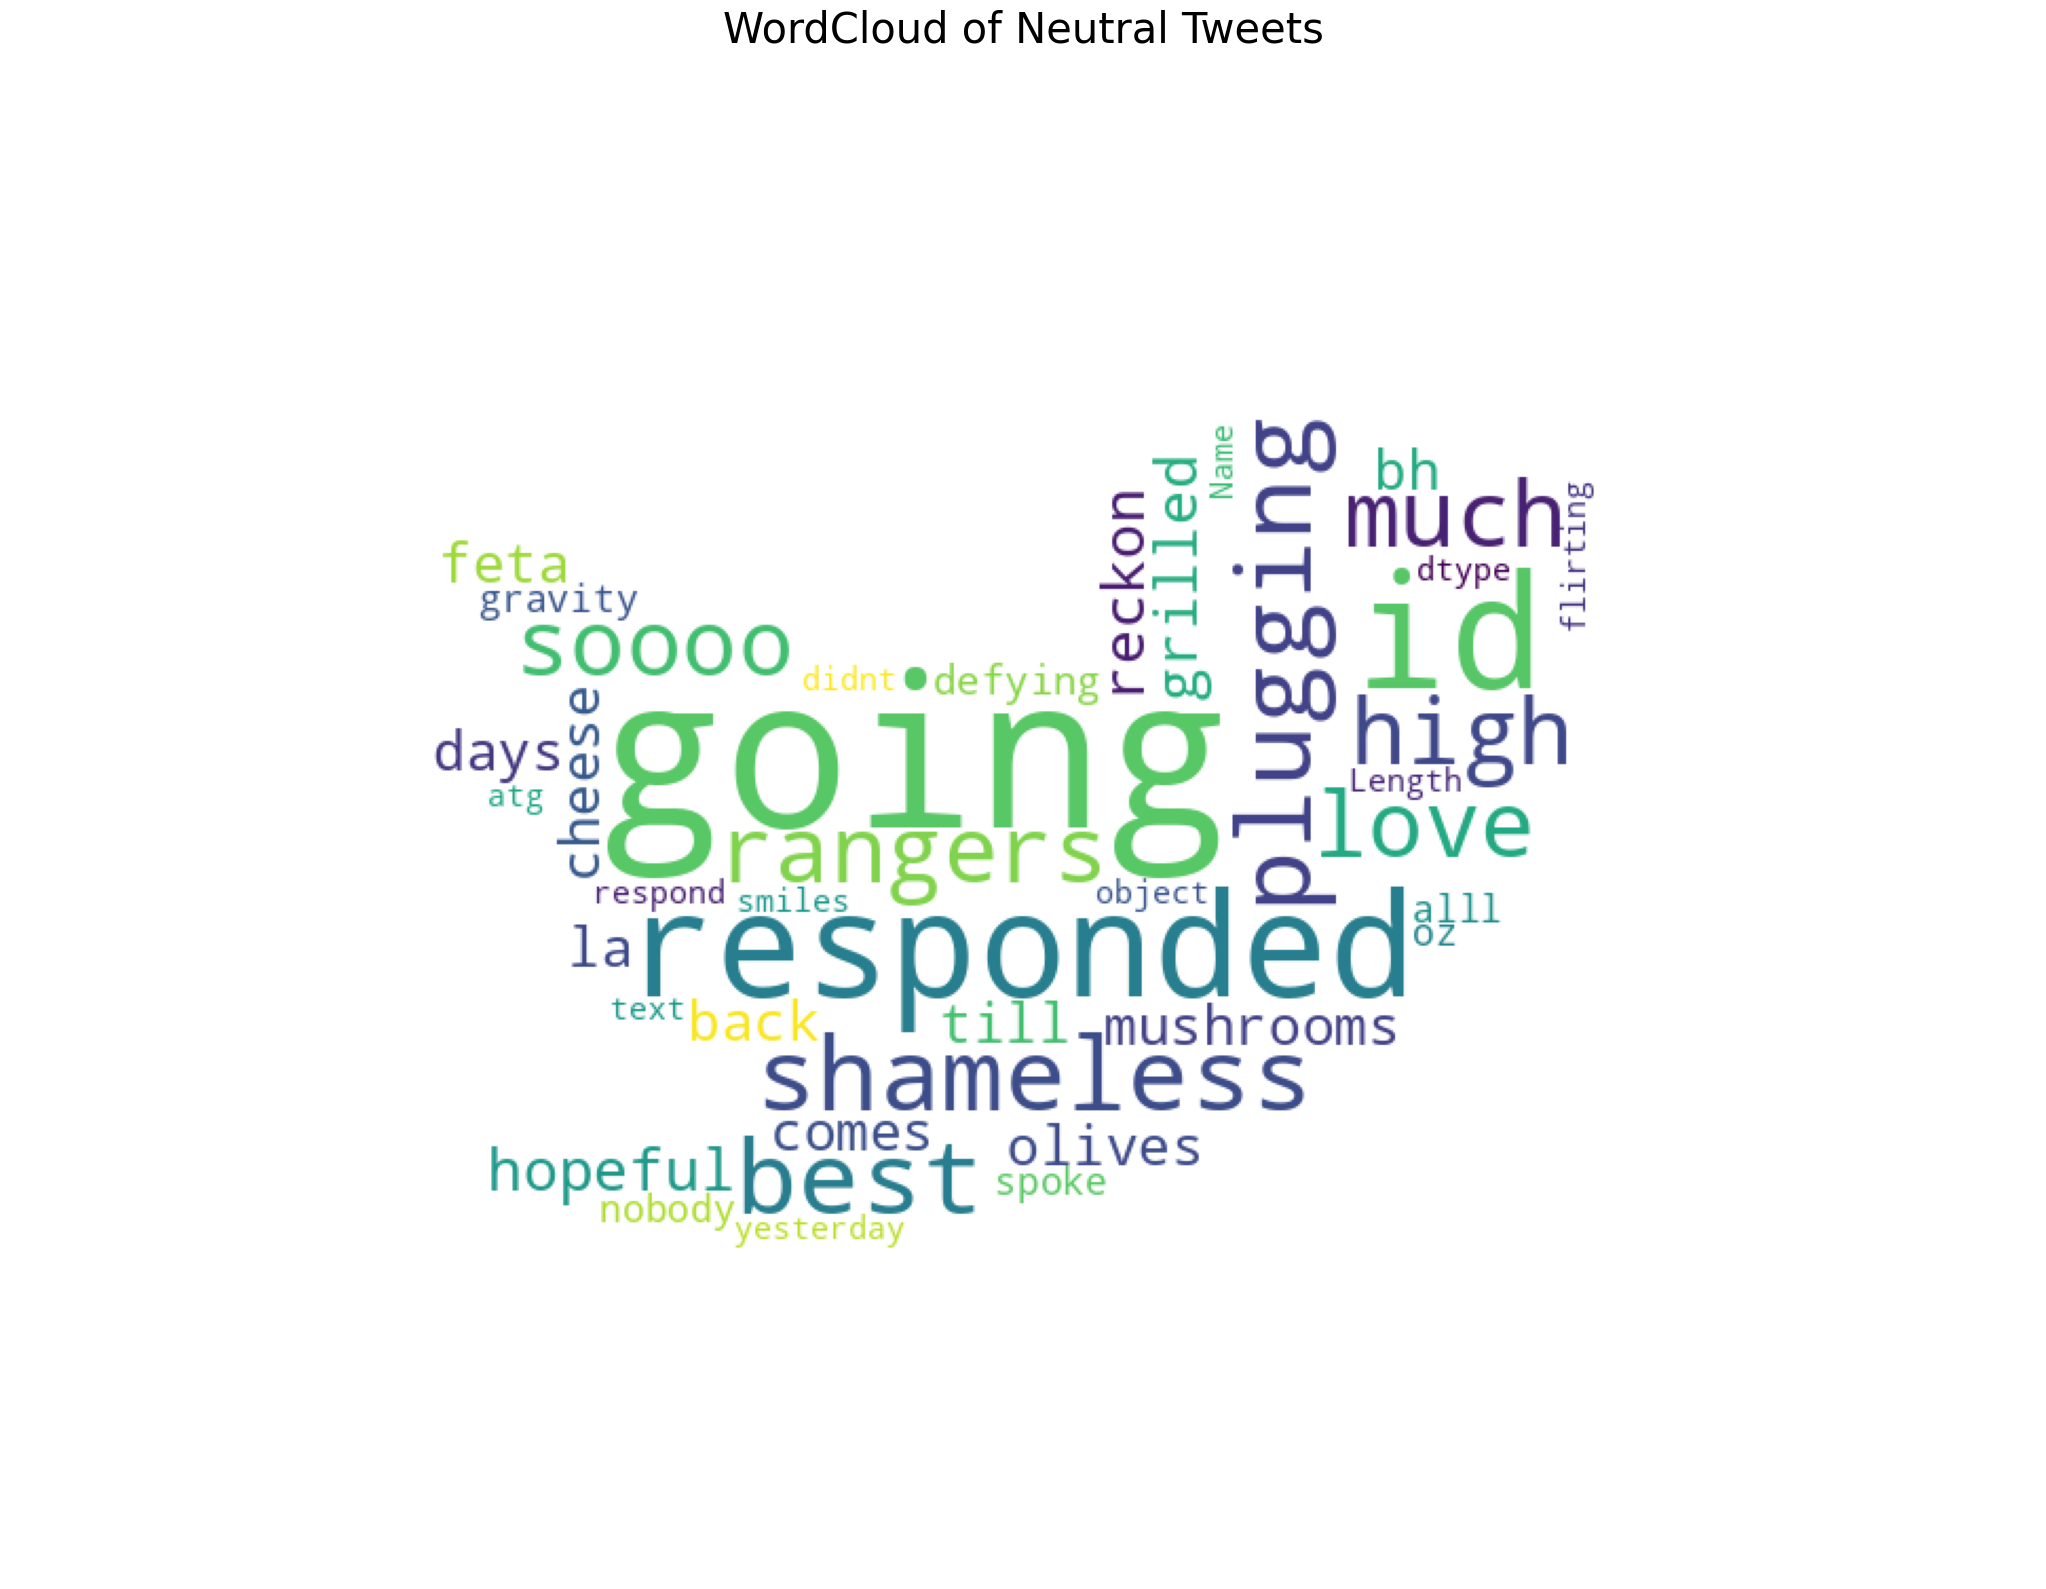

In [65]:
plot_wordcloud(Neutral_sent.text, mask=pos_mask, color='white', max_font_size=100,
               title_size=30, title="WordCloud of Neutral Tweets")

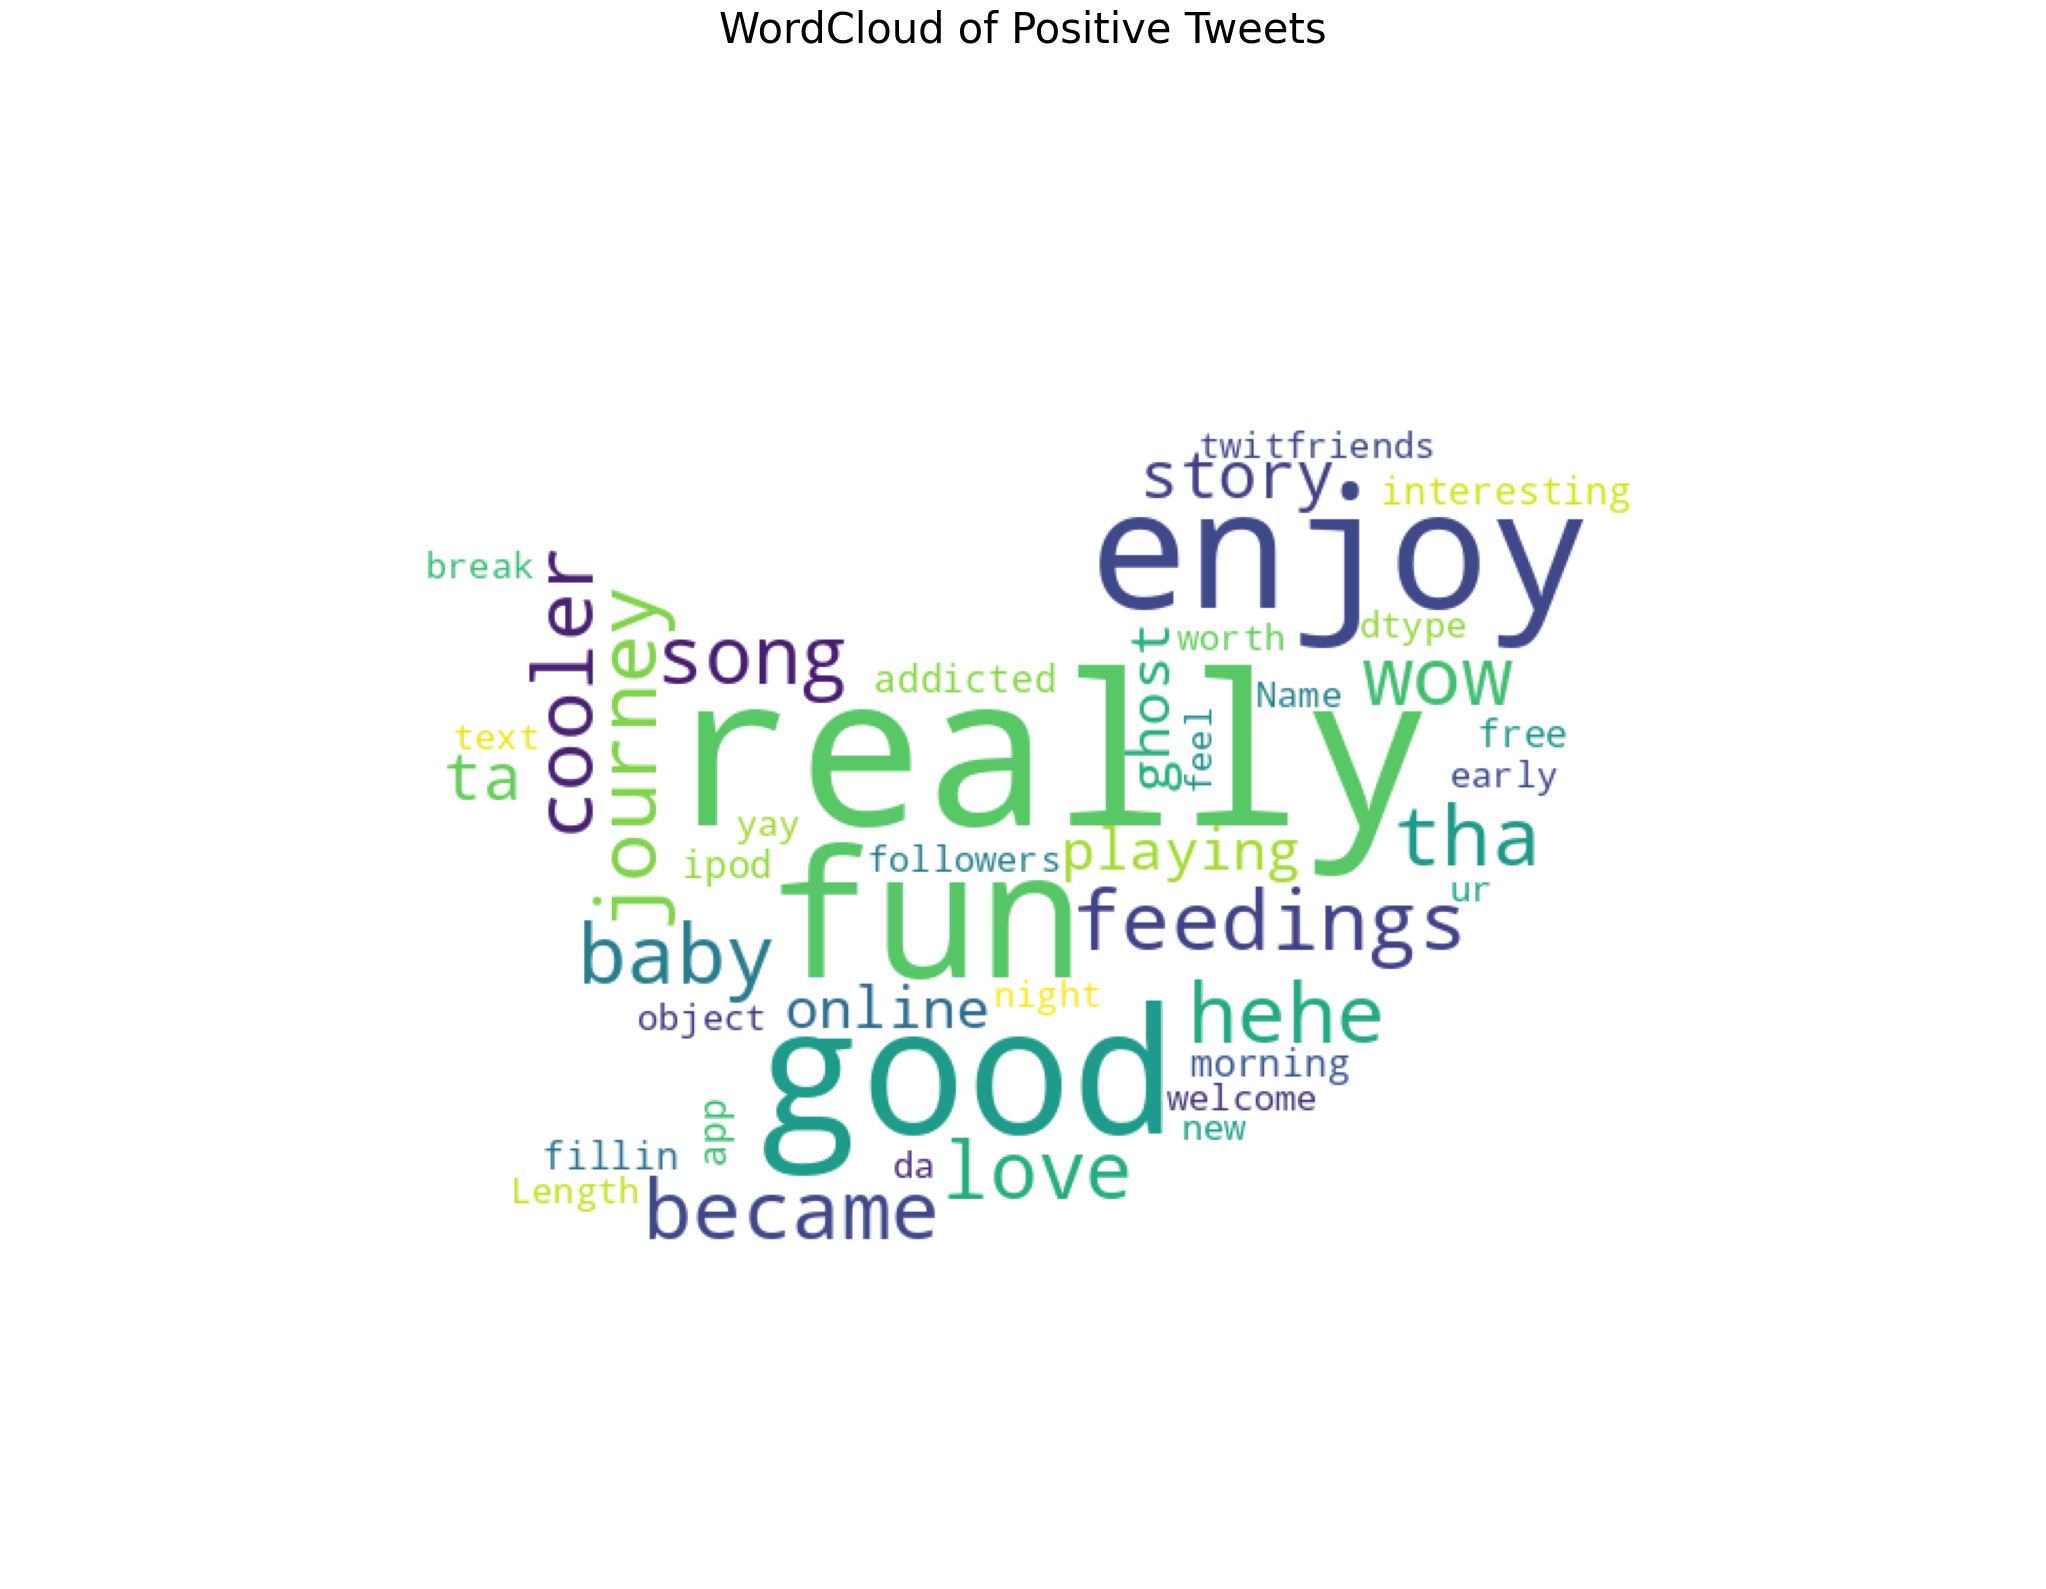

In [64]:
plot_wordcloud(Positive_sent.text, mask=pos_mask, title_size=30, title="WordCloud of Positive Tweets")

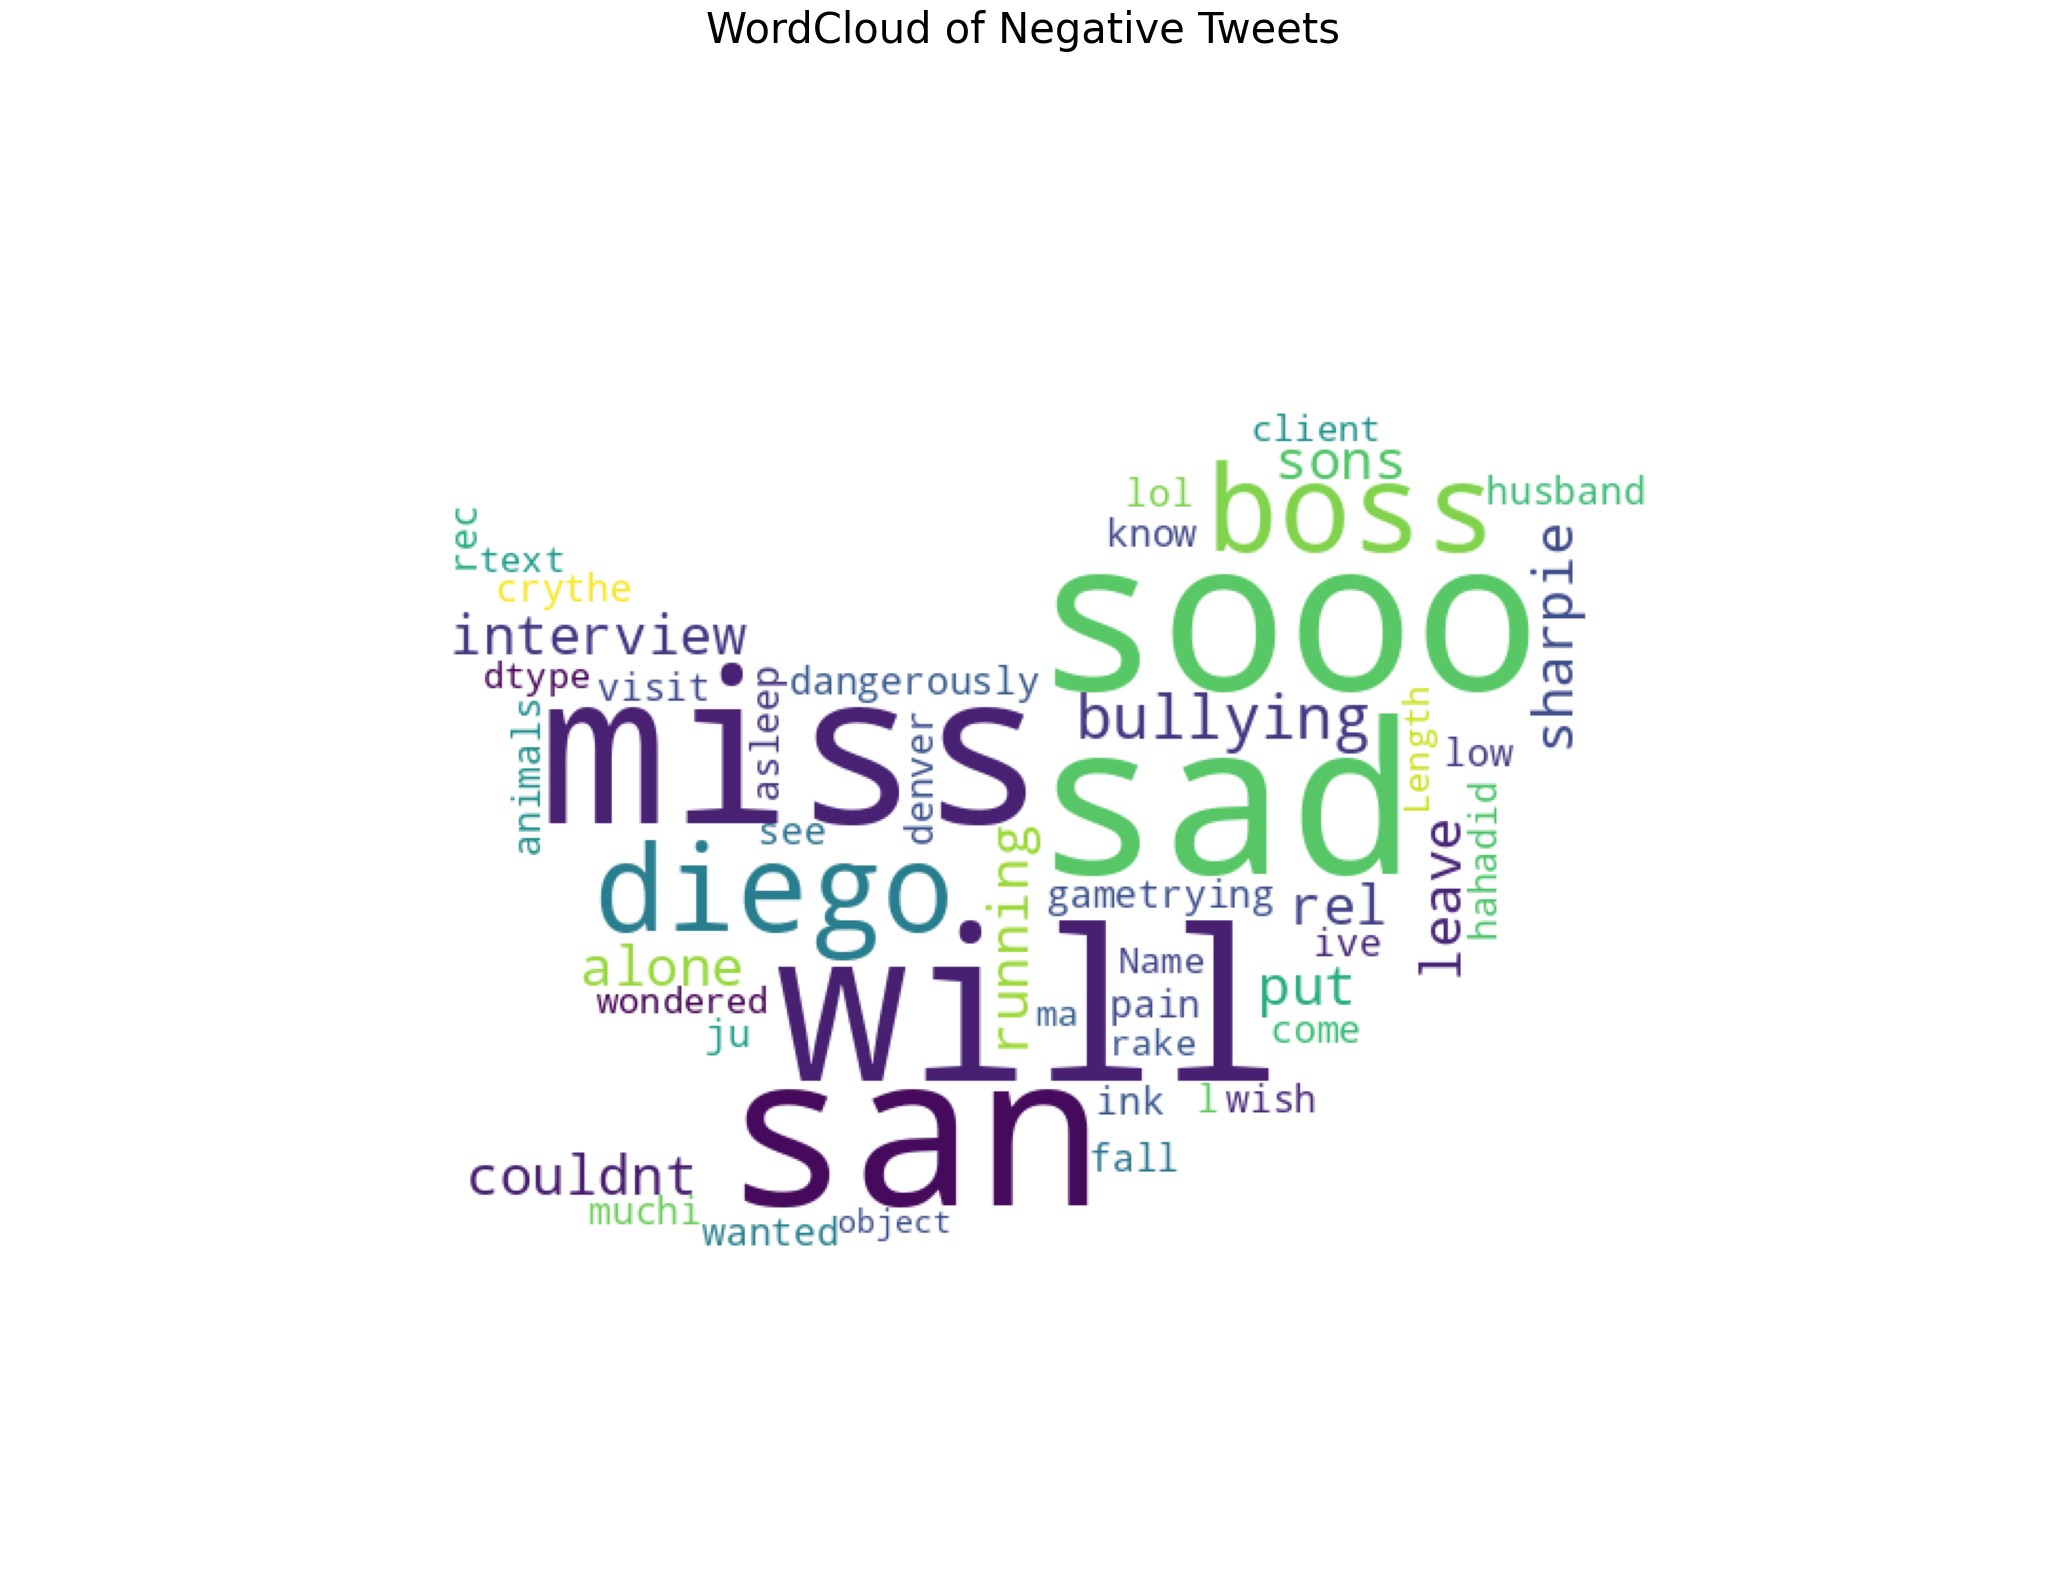

In [66]:
plot_wordcloud(Negative_sent.text, mask=pos_mask, color='white',  title_size=30, title="WordCloud of Negative Tweets")